Serial port opened successfully.
start signal written
confirm signal received
start signal written
confirm signal received
start signal written
confirm signal received
start signal written
confirm signal received
start signal written
confirm signal received
start signal written
confirm signal received
start signal written
confirm signal received
start signal written
confirm signal received
start signal written
confirm signal received
start signal written
confirm signal received
start signal written
confirm signal received
start signal written
confirm signal received
start signal written
confirm signal received
start signal written
confirm signal received
start signal written
confirm signal received
start signal written
confirm signal received
start signal written
confirm signal received
start signal written
confirm signal received
start signal written
confirm signal received
start signal written
confirm signal received
start signal written
confirm signal received
start signal written
c

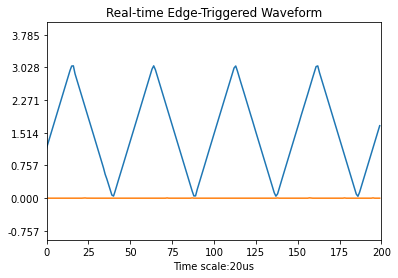

In [2]:
import tkinter as tk
from tkinter import simpledialog
import serial
from time import sleep
from tkinter import ttk

# 串口打开函数
def open_ser():
    port = 'COM4'  # 串口号
    baudrate = 115200  # 波特率
    try:
        global ser
        ser = serial.Serial(port, baudrate, timeout=0.5)
        if ser.isOpen() == True:
            print("Serial port opened successfully.")
    except Exception as exc:
        print("Serial port opened unsuccessfully", exc)
    

# 初始化data列表，长度调整为21位或更多，根据需要
data = ['0'] * 25

####################################
# 定义开始信号、结束信号和确认信号
START_SIGNAL = 'SSTART\n'+18*'0'
FINISH_SIGNAL = 'FINISH\n'
CONFIRM_SIGNAL = 'ACKACK\n'
#定义开关控制信号
S1_HIGH = 'H1'+23*'0'
S2_HIGH = 'H2'+23*'0'
S3_HIGH = 'H3'+23*'0'
S4_HIGH = 'H4'+23*'0'
S1_LOW = 'L1'+23*'0'
S2_LOW = 'L2'+23*'0'
S3_LOW = 'L3'+23*'0'
S4_LOW = 'L4'+23*'0'
# 定义全局水平缩放因子和垂直偏移量
horizental_scale = 2
vertical_offset1 = 0
vertical_offset2 = 0
trigger_value = 1500  # 初始触发值
#############################################

# 打开一个新窗口让用户输入数据的函数
def open_input_window1():
    # 创建新窗口
    waveform = tk.Toplevel()
    waveform.title("waveform generator")

    # 单选按钮PA4和PA5
    pa_var = tk.StringVar(value="PA4")
    tk.Radiobutton(waveform, text="PA4", variable=pa_var, value="PA4").grid(row=0, column=0)
    tk.Radiobutton(waveform, text="PA5", variable=pa_var, value="PA5").grid(row=0, column=1)

    # 单选按钮sin, cos, triangle
    func_var = tk.StringVar(value="00")  # 默认为sin
    tk.Radiobutton(waveform, text="sin", variable=func_var, value="00").grid(row=1, column=0)
    tk.Radiobutton(waveform, text="cos", variable=func_var, value="01").grid(row=1, column=1)
    tk.Radiobutton(waveform, text="sawtooth", variable=func_var, value="10").grid(row=1, column=2)

    # 周期值输入
    tk.Label(waveform, text="period").grid(row=2, column=0)
    ns_entry = tk.Entry(waveform)
    ns_entry.grid(row=2, column=1, columnspan=2)

    # 频率值输入
    tk.Label(waveform, text="frequency").grid(row=3, column=0)
    frequency_entry = tk.Entry(waveform)
    frequency_entry.grid(row=3, column=1, columnspan=2)

    # 幅值输入
    tk.Label(waveform, text="apmlitude").grid(row=4, column=0)
    apm_entry = tk.Entry(waveform)
    apm_entry.grid(row=4, column=1, columnspan=2)

    # 偏移值输入
    tk.Label(waveform, text="dc offset").grid(row=5, column=0)
    ds_entry = tk.Entry(waveform)
    ds_entry.grid(row=5, column=1, columnspan=2)

    def update_data():
      # 基于用户的选择更新data字符串
      # 前两位由PA4/PA5单选按钮决定
      if pa_var.get() == 'PA4':
          data[0] = 's'
          data[1] = '1'
      else:
          data[0] = 's'
          data[1] = '2'
    
      # 第二、三位由sin/cos/triangle单选按钮决定
      data[2:4] = func_var.get()
    
      # 四五六位存储周期值
      ns_value = ns_entry.get().zfill(3)
      data[4:7] = list(ns_value)[:3]
    
      # 七到十三位存储频率值
      frequency_value = frequency_entry.get().zfill(7)
      data[7:14] = list(frequency_value)[:7]
    
      # 十四到十七位存储幅值
      apm_value = apm_entry.get().zfill(4)
      data[14:18] = list(apm_value)[:4]
    
      # 十八位及之后存储偏移值
      ds_value = ds_entry.get().zfill(2)
      data[18:20] = list(ds_value)[:2]
    
      # 打印data值
      print(''.join(data))
      ser.write(str(''.join(data)).encode('utf-8'))
    # 确认按钮
    confirm_button = tk.Button(waveform, text="confirm", command=update_data)
    confirm_button.grid(row=6, column=0, columnspan=3)


def open_input_window2():
    import serial
    import numpy as np
    import matplotlib.pyplot as plt
    import tkinter as tk
    from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
    from tkinter import Scale

#     # 打开串口
#     ser = serial.Serial('COM4', 115200)  # 替换成你的串口号和波特率

    ser.reset_input_buffer()
    ser.reset_output_buffer()



    # 创建一个 Tkinter 窗口
    root = tk.Toplevel()
    root.title('Triggered Data Buffer')

    # 创建一个 Figure 对象和一个子图
    fig, ax = plt.subplots()
    line, = ax.plot([])
    line0, = ax.plot([])  # 用于绘制第二条线

    # 设置子图属性
    ax.set_title('Real-time Edge-Triggered Waveform')

    # 创建一个 FigureCanvasTkAgg 对象
    canvas = FigureCanvasTkAgg(fig, master=root)
    canvas_widget = canvas.get_tk_widget()
    canvas_widget.grid(row=0, column=0, columnspan=3)  # 将其放置在第一行的所有列中

    # 创建用于显示当前trigger值的文本框
    trigger_value_label = tk.Label(root, text="<Horizental position>")
    trigger_value_label.grid(row=6, column=0)

    # 创建一个滑动条用于调整触发值
    trigger_value_scale = Scale(root, from_=1200, to=4000, orient=tk.HORIZONTAL, length=200)
    trigger_value_scale.set(trigger_value)  # 设置初始值
    trigger_value_scale.grid(row=6, column=1)

    # 创建用于显示幅值 Vpp 的文本框
    vpp_label = tk.Label(root, text="Amplitude Vpp (V):")
    vpp_label.grid(row=1, column=0)

    vpp_text = tk.StringVar()
    vpp_text.set("")
    vpp_entry = tk.Entry(root, textvariable=vpp_text, state='readonly')
    vpp_entry.grid(row=1, column=1)

    # 创建用于显示频率的文本框
    frequency_label = tk.Label(root, text="Frequency (Hz):")
    frequency_label.grid(row=2, column=0)

    frequency_text = tk.StringVar()
    frequency_text.set("")
    frequency_entry = tk.Entry(root, textvariable=frequency_text, state='readonly')
    frequency_entry.grid(row=2, column=1)

    # 创建用于输入水平缩放因子的文本框
    horizental_scale_label = tk.Label(root, text="Horizental Scale:")
    horizental_scale_label.grid(row=3, column=0)

    # 创建一个滑动条用于调整水平缩放因子
    horizental_scale_scale = Scale(root, from_=1, to=5, orient=tk.HORIZONTAL, length=200)
    horizental_scale_scale.set(horizental_scale)  # 设置初始值
    horizental_scale_scale.grid(row=3, column=1)

    # 创建用于输入垂直偏移量的文本框
    vertical_offset1_label = tk.Label(root, text="^\n Vertical Position CH1\n v")
    vertical_offset1_label.grid(row=4, column=0)

    # 创建一个滑动条用于调整垂直偏移量
    vertical_offset1_scale = Scale(root, from_=-500, to=500, orient=tk.HORIZONTAL, length=200)
    vertical_offset1_scale.set(vertical_offset1)  # 设置初始值
    vertical_offset1_scale.grid(row=4, column=1)

    # 创建用于输入垂直偏移量2的文本框
    vertical_offset2_label = tk.Label(root, text="^\n Vertical Position CH2\n v")
    vertical_offset2_label.grid(row=5, column=0)

    # 创建一个滑动条用于调整垂直偏移量2
    vertical_offset2_scale = Scale(root, from_=-500, to=500, orient=tk.HORIZONTAL, length=200)
    vertical_offset2_scale.set(vertical_offset2)  # 设置初始值
    vertical_offset2_scale.grid(row=5, column=1)

    # 创建提示标签
    hint_label = tk.Label(root, text="Please Press Exit Button to Quit")
    hint_label.grid(row=4, column=3, rowspan=7)

    # 创建 CH1 和 CH2 按钮的点击事件处理函数
    def toggle_channel(channel):
        if channel == 1:
            if line.get_visible():
                line.set_visible(False)
            else:
                line.set_visible(True)
        elif channel == 2:
            if line0.get_visible():
                line0.set_visible(False)
            else:
                line0.set_visible(True)
        plt.draw()

    # 创建 CH1 按钮
    ch1_button = tk.Button(root, text="CH1", command=lambda: toggle_channel(1))
    ch1_button.grid(row=3, column=3)

    # 创建 CH2 按钮
    ch2_button = tk.Button(root, text="CH2", command=lambda: toggle_channel(2))
    ch2_button.grid(row=4, column=3)

    def update_data_buffer():
        global ser
        global START_SIGNAL, CONFIRM_SIGNAL, FINISH_SIGNAL
        global horizental_scale, vertical_offset1, trigger_value

        # 发送开始信号给下位机
        ser.write(START_SIGNAL.encode('utf-8'))
        print("start signal written")
        while ser.readline().decode('utf-8') != CONFIRM_SIGNAL:
            print("waiting for confirm signal")

        print("confirm signal received")

        byte_data_frame = ser.read(4000)
        data_frame = np.frombuffer(byte_data_frame, dtype='uint16')

        # 提取触发后的数据缓冲区数据
        ADCPA1 = data_frame[:1000]
        ADCPA0 = data_frame[1000:2000]  # 提取ADCPA0数据

        trigger_indices = np.where(np.diff(ADCPA1 > trigger_value))[0]
        next_trigger_index = trigger_indices[2]

        if len(trigger_indices) > 0:
            trigger_index = trigger_indices[0]
            if trigger_index < len(ADCPA1) - 1 and ADCPA1[trigger_index + 1] > trigger_value:
                # 设置水平缩放因子
                data_buffer1 = ADCPA1[trigger_index + 1:trigger_index + 100 * horizental_scale + 1]
                data_buffer0 = ADCPA0[trigger_index + 1:trigger_index + 100 * horizental_scale + 1]  # 提取ADCPA0数据

                # 更新数据缓冲区（加上垂直偏移量）
                data_buffer1 = data_buffer1 + vertical_offset1
                data_buffer0 = data_buffer0 + vertical_offset2  # 对ADCPA0应用相同的垂直偏移量

                # 更新图形
                line.set_data(range(len(data_buffer1)), data_buffer1)
                line0.set_data(range(len(data_buffer0)), data_buffer0)  # 绘制ADCPA0数据

                # 更新幅值 Vpp
                vpp_value = (np.max(data_buffer1) - np.min(data_buffer1)) * 0.000757
                vpp_text.set("{:.3f}".format(vpp_value))

                # 计算频率
                if len(trigger_indices) > 1:
                    time_diff = (trigger_indices[2] - trigger_indices[0]) * 20  # 假设每个间隔为20 us
                    frequency = 1 / (time_diff / 1e6)  # 转换为 Hz
                    frequency_text.set("{:.2f}".format(frequency))

                else:
                    frequency_text.set("N/A")

                # 动态调整 X 轴范围
                ax.set_xlim(0, len(data_buffer1))

                # 动态调整 Y 轴范围和中心点
                data_min = np.min(data_buffer1)
                data_max = np.max(data_buffer1)
                data_range = data_max - data_min
                buffer_extension = data_range / 3

                ax.set_ylim(data_min - buffer_extension, data_max + buffer_extension)
                # 转换 Y 轴刻度标签为以 0.000757 V 为单位的值
               # 转换 Y 轴刻度标签为以 0.000757 V 为单位的值
                def volts_formatter(x, pos):
                    return '{:.3f}'.format(x * 0.000757)


                # 设置 Y 轴刻度标签格式
                ax.yaxis.set_major_formatter(plt.FuncFormatter(volts_formatter))
                
                ax.set_xlabel('Time scale:20us')



                canvas.draw()

        # 循环调用更新函数，实现实时更新
        root.after(10, update_data_buffer)

    # 调用更新函数
    update_data_buffer()

    # 绑定滑动条的事件处理函数，用于更新触发值
    def update_trigger_value(value):
        global trigger_value
        trigger_value = int(value)
#         trigger_value_text.set(str(trigger_value))

    # 绑定滑动条的事件处理函数，用于更新垂直偏移量
    def update_vertical_offset1(value):
        global vertical_offset1
        vertical_offset1 = int(value)
        vertical_offset1_text.set(str(vertical_offset1))

    # 绑定滑动条的事件处理函数，用于更新垂直偏移量2
    def update_vertical_offset2(value):
        global vertical_offset2
        vertical_offset2 = int(value)
        vertical_offset2_text.set(str(vertical_offset2))

    # 绑定滑动条的事件处理函数，用于更新缩放值
    def update_horizental_scale(value):
        global horizental_scale
        horizental_scale = int(value)
        horizental_scale_text.set(str(horizental_scale*10))

    # 绑定退出按钮事件处理函数
    def exit_and_close_serial():
        global ser
        if ser.is_open:
            ser.close()  # 关闭串口
        root.destroy()  # 退出 Tkinter 窗口


    # 创建一个退出按钮
    exit_button = tk.Button(root, text="Exit", command=exit_and_close_serial)
    exit_button.grid(row=2, column=3)


    # 绑定滑动条事件
    trigger_value_scale.config(command=update_trigger_value)
    # 绑定滑动条事件
    vertical_offset1_scale.config(command=update_vertical_offset1)
    # 绑定滑动条事件
    vertical_offset2_scale.config(command=update_vertical_offset2)
    # 绑定滑动条的事件处理函数，用于更新水平缩放因子
    horizental_scale_scale.config(command=update_horizental_scale)

    # 运行 Tkinter 事件循环
    root.mainloop()

    
# 初始状态为关闭
sw1_status = False
sw2_status = False
sw3_status = False
sw4_status = False

def toggle_sw(channel):
    global sw1_status, sw2_status, sw3_status, sw4_status
    if channel == 1:
        sw1_status = not sw1_status
        if sw1_status:
            ser.write(S1_HIGH.encode('utf-8'))
            print('Attu1', sw1_status)
        else:
            ser.write(S1_LOW.encode('utf-8'))
            print('Attu1', sw1_status)
    elif channel == 2:
        sw2_status = not sw2_status
        if sw2_status:
            ser.write(S2_HIGH.encode('utf-8'))
            print('CH1 Ac coupling', sw2_status)
        else:
            ser.write(S2_LOW.encode('utf-8'))
            print('CH1 Ac coupling', sw2_status)
    elif channel == 3:
        sw3_status = not sw3_status
        if sw3_status:
            ser.write(S3_HIGH.encode('utf-8'))
            print('Attu3', sw3_status)
        else:
            ser.write(S3_LOW.encode('utf-8'))
            print('Attu3', sw3_status)
    elif channel == 4:
        sw4_status = not sw4_status
        if sw4_status:
            ser.write(S4_HIGH.encode('utf-8'))
            print('CH2 Ac coupling', sw4_status)
        else:
            ser.write(S4_LOW.encode('utf-8'))
            print('CH2 Ac coupling', sw4_status)



if __name__ == '__main__':
    ser = None
    open_ser()  # 打开串口
    # 主窗口
    root = tk.Tk()  # 创建窗口
    root.title('mode selection')
    root.geometry("500x400+630+80")  # (宽度x高度)+(x轴+y轴)


    # 创建按钮打开输入窗口
    button1 = tk.Button(root, text="waveform generator", command=open_input_window1)
    button1.pack()
    
    #提示文本
    text_label = tk.Label(root, text="Please finish oscilloscpoe setting and then open oscilloscope")
    text_label.pack()
    # 在示波器按钮旁边添加四个按钮
    text_label = tk.Label(root, text="Please press Attu1 when CH1 input vpp >1V")
    text_label.pack()
    s1_button = tk.Button(root, text="Attu1", command=lambda: toggle_sw(1))
    s1_button.pack()
    s2_button = tk.Button(root, text="Ch1 Ac coupling", command=lambda: toggle_sw(2))
    s2_button.pack()
    text_label = tk.Label(root, text="Please press Attu2 when CH2 input vpp >1V")
    text_label.pack()
    s3_button = tk.Button(root, text="Attu2", command=lambda: toggle_sw(3))
    s3_button.pack()
    s4_button = tk.Button(root, text="Ch2 Ac coupling", command=lambda: toggle_sw(4))
    s4_button.pack()
    
    
    
    button1 = tk.Button(root, text="oscilloscope", command=open_input_window2)
    button1.pack()
    
    
    root.mainloop()
